## Predict SVHN dataset using efficientnet

In [27]:
from __future__ import print_function

import os
import pickle

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

# from keras.applications.imagenet_utils import decode_predictions

from efficientnet.tfkeras import EfficientNetB0
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input

import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings 
warnings.simplefilter(action='ignore')

In [3]:
# !pip install opencv-python
# !pip install efficientnet

In [4]:
keras.__version__, tf.__version__

('2.2.4-tf', '1.13.1')

### Download dataset

http://ufldl.stanford.edu/housenumbers/

In [5]:
# !wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
# !wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat
# !wget http://ufldl.stanford.edu/housenumbers/extra_32x32.mat

In [6]:
from scipy.io import loadmat
train = loadmat('train_32x32.mat')
test  = loadmat('test_32x32.mat')
extra = loadmat('extra_32x32.mat')

### Data Preprocessing


In [7]:
# select labeled data for teacher model training
num_label = 5000
num_classes = 10

In [8]:
x_train, y_train = train['X'],train['y']
x_test,  y_test  = test['X'], test['y']
x_extra, y_extra = extra['X'],extra['y']

# combine the train file and extra file
x_train = np.concatenate((x_train,x_extra),axis=3)
y_train = np.concatenate((y_train,y_extra),axis=0)

# move the number of samples to the first position
x_train = np.moveaxis(x_train,-1,0)
x_test1  = np.moveaxis(x_test,-1,0)

# preprocessing of x_test and y_test, details see below function "preprocessing_xy"
x_test1  = x_test1.astype('float32')
x_test1  /= 255
y_test   = y_test.reshape(y_test.shape[0],)
y_test[y_test==10]     = 0
y_test1     = keras.utils.to_categorical(y_test,  num_classes, dtype='uint8')

# split data to to be used and not to be used by num_label
# only do preprocessing for the data to be used to avoid halted run
x_train1, x_unused1, y_train1, y_unused1 = train_test_split(
    x_train,y_train, train_size=num_label, random_state=31, shuffle=True)

In [9]:
# release some memory 
del x_train, y_train, x_test,  y_test, x_extra, y_extra

In [10]:
def preprocessing_xy(x_train1, y_train1):
    x_train1 = x_train1.astype('float32')
    
    # Normilize data
    x_train1 /= 255
    
    # convert class vectors to binary class matrices
    y_train1 = y_train1.reshape(y_train1.shape[0],)

    # In original dataset, Digit '1' has label 1, '9' has label 9 and '0' has label 10.
    # Now we change it to: Digit '1' has label 1, '9' has label 9 and '0' has label 0.
    y_train1[y_train1==10] = 0

    # one hot encoding
    y_train1    = keras.utils.to_categorical(y_train1, num_classes, dtype='uint8')
    
    return x_train1, y_train1

x_train1, y_train1 = preprocessing_xy(x_train1, y_train1)

# backup them before validation split so we can combine these images with unlabelled ones later!
x_train1_backup = x_train1.copy()
y_train1_backup = y_train1.copy()

In [11]:
# split training & validation set
x_train1, x_valid1, y_train1, y_valid1 = train_test_split(x_train1,y_train1, test_size=0.1, random_state=31,shuffle=True)

x_train shape: (4500, 32, 32, 3)
y_train shape: (4500, 10)
4500 train samples
500 validation samples
26032 test samples
[1 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 1] [0 0 1 0 0 0 0 0 0 0]


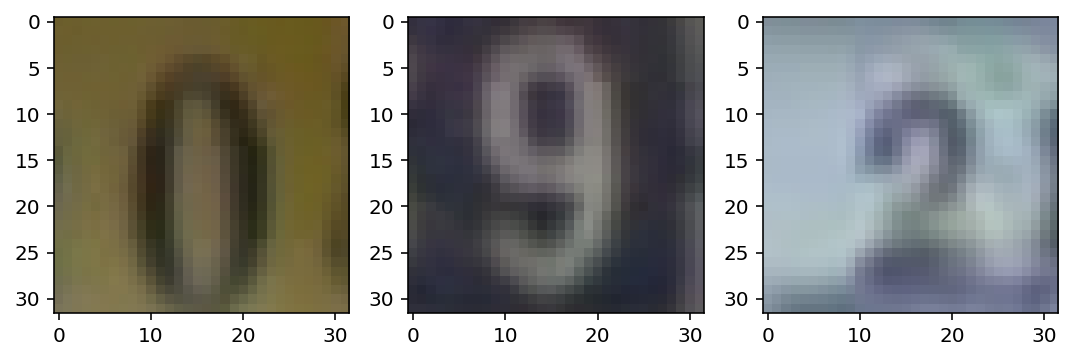

In [12]:
print('x_train shape:', x_train1.shape)
print('y_train shape:', y_train1.shape)
print(x_train1.shape[0], 'train samples')
print(x_valid1.shape[0], 'validation samples')
print(x_test1.shape[0], 'test samples')

# check the first sample in training set & test set
fig,axes = plt.subplots(figsize=(9,4),ncols=3)
axes[0].imshow(x_train1[1])
axes[1].imshow(x_valid1[1])
axes[2].imshow(x_test1[1])
print(y_train1[1],y_valid1[1],y_test1[1])

### Data augmentation for Teacher - Nothing at all!

reference: https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model_name = 'teachermodel_5000i_SVHN_50e_744v_drop05' #'teachermodel_first_SVHN'

if 'teacher' in model_name:
    aug = ImageDataGenerator()

# no need to fit for validation data because we want the validation to be original images
aug.fit(x_train1)

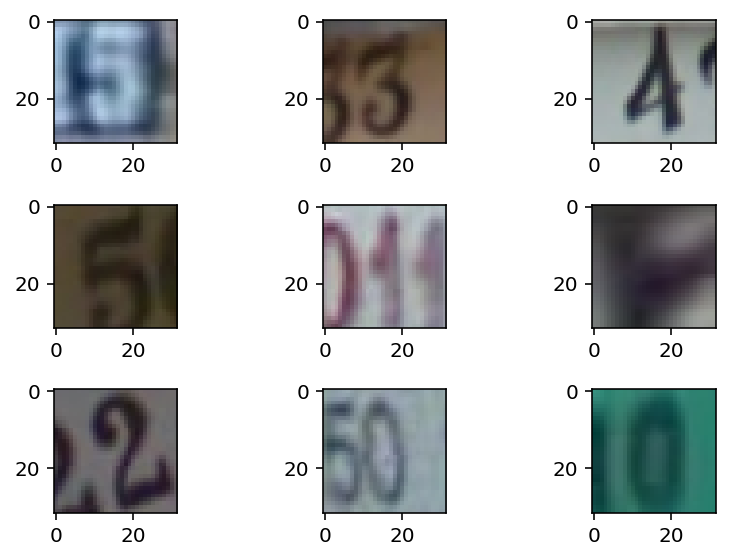

In [19]:
for X_batch, y_batch in aug.flow(x_train1, y_train1, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    # show the plot
#     plt.show()
    plt.tight_layout()
    break

### Build and train teacher model

In [15]:
# loading pretrained model
img_size   = 32
base_model = EfficientNetB0(weights='imagenet',input_shape=(img_size,img_size,3),include_top=False)
# base_model.trainable = False

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
# check if the pre-trained model is trainable:
for layers in base_model.layers:
    print(layers.trainable)
    break

True


In [21]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x) # once used 0.2 too but not as good as 0.5
predictions = Dense(units = 10, activation="softmax")(x)
model = Model(inputs = base_model.input, outputs = predictions)

# model.summary()

In [22]:
# Here we use F1-score and categorical_accuracy as evaluation metrics
import keras.backend as K

def f1_m(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

model.compile(optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['categorical_accuracy', f1_m])

In [23]:
batch_size  = 128
epochs = 50

H = model.fit_generator(
    aug.flow(x_train1, y_train1, batch_size=batch_size),
    epochs=epochs,
    steps_per_epoch=len(x_train1) // batch_size,
    validation_data=(x_valid1,y_valid1),
    verbose=0) 

Instructions for updating:
Use tf.cast instead.
500/500 [==============================] - 1s 2ms/sample - loss: 1.3695 - categorical_accuracy: 0.7300 - f1_m: 0.7044


### Save the model & training process

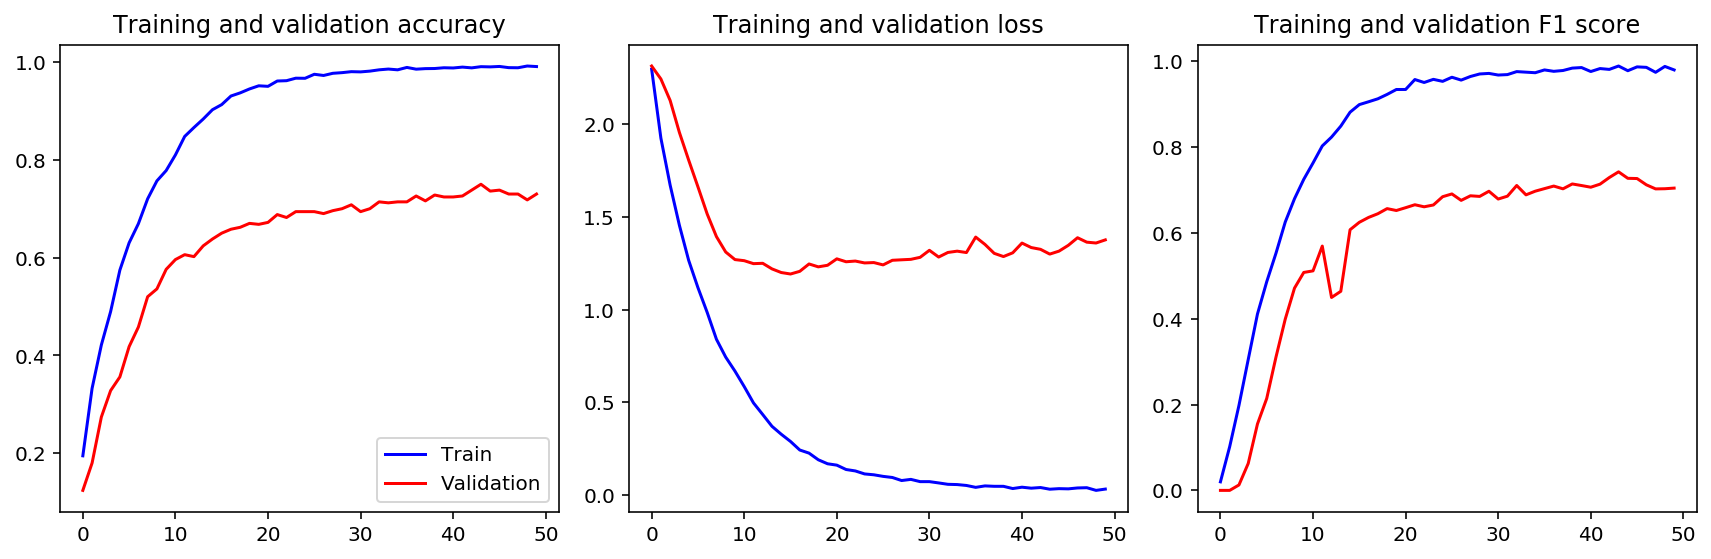

In [28]:
def plot_training(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f1 = history.history['f1_m']
    val_f1 = history.history['val_f1_m']
    epochs = range(len(acc))

    fig, axes = plt.subplots(figsize=(12,4),ncols=3)

    axes[0].plot(epochs, acc, 'b',label='Train')
    axes[0].plot(epochs, val_acc, 'r',label='Validation')
    axes[0].set_title('Training and validation accuracy')
    axes[0].legend()


    axes[1].plot(epochs, loss, 'b')
    axes[1].plot(epochs, val_loss, 'r')
    axes[1].set_title('Training and validation loss')


    axes[2].plot(epochs, f1, 'b')
    axes[2].plot(epochs, val_f1, 'r')
    axes[2].set_title('Training and validation F1 score')


def save_and_plot(model, model_name, H):
    # save the final model
    model.save("./models/"+model_name+".hdf5")
    
    plot_training(H)
    plt.tight_layout()
    plt.rcParams['savefig.dpi'] = 220
    plt.savefig('./Figures/'+model_name+'.png')
    
    # save the evolultion process of the metrics during training
    pickle_name = './models/'+model_name+'.pckl'
    os.makedirs(os.path.dirname(pickle_name), exist_ok=True)
    f = open(pickle_name, 'wb')
    pickle.dump(H.history, f)
    f.close()
    
save_and_plot(model, model_name, H)

### Generate psuedo labels - round 1

In [30]:
# -------- YOU NEED TO CHANGE ---------
R = 2
num_unlabel = num_label * R

# select unlabeled data from unused data(x_unused,y_unused)
x_unlabel1, x_unused2, y_unlabel1, y_unused2 = train_test_split(
    x_unused1,y_unused1, train_size=num_unlabel, random_state=31,shuffle=True)

In [31]:
del x_unused1,y_unused1

In [32]:
x_unlabel1.shape,y_unlabel1.shape

((10000, 32, 32, 3), (10000, 1))

In [33]:
# Restore teacher model
model_teacher = 'teachermodel_5000i_SVHN_50e_744v_drop05' 
# model_name

from tensorflow.keras.models import load_model
teacher_model = load_model("./models/"+model_teacher+".hdf5", custom_objects={"f1_m": f1_m})

In [34]:
# Predict psuedo labels
y_proba1 = teacher_model.predict(x_unlabel1)
y_unlabel1 = np.argmax(y_proba1, axis=1)

In [35]:
x_unlabel1, y_unlabel1 = preprocessing_xy(x_unlabel1, y_unlabel1)

In [36]:
# Combine label & unlabel1
# NOTE because x_train1 is actually not augmented so we can combine together
# In the next round, we cannot combine the date without augmentation and with augmentation! So we need a back up!
x_train2 = np.concatenate((x_train1_backup,x_unlabel1),axis=0)
y_train2 = np.concatenate((y_train1_backup,y_unlabel1),axis=0)

del x_train1, x_valid1, x_unlabel1, y_train1, y_valid1, y_unlabel1, y_proba1, x_train1_backup, y_train1_backup

x_train2_backup = x_train2.copy()
y_train2_backup = y_train2.copy()

In [37]:
np.shape(x_train2)

(15000, 32, 32, 3)

In [38]:
# split training & validation set
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(x_train2,y_train2, test_size=0.1, random_state=31,shuffle=True)

### Data augmentation for Student1

In [ ]:
model_name = 'studentmodel1_5000i_SVHN_50e_744v_drop05_iter1' #'teachermodel_first_SVHN'

aug_student = ImageDataGenerator(rotation_range=10,
                                 zoom_range=0.05,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.11,
                                 # horizontal_flip=True,
                                 fill_mode="nearest")

if 'student' in model_name:
    aug = aug_student

# no need to fit for validation data because we want the validation to be original images
aug.fit(x_train2)

In [ ]:
for X_batch, y_batch in aug.flow(x_train2, y_train2, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    # show the plot
#     plt.show()
    plt.tight_layout()
    break

### Build Student1

In [ ]:
# loading pretrained model
base_model = EfficientNetB0(weights='imagenet',input_shape=(img_size,img_size,3),include_top=False)
# base_model.trainable = False

# check if the pre-trained model is trainable:
for layers in base_model.layers:
    print(layers.trainable)
    break
    
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(units = 10, activation="softmax")(x)
model = Model(inputs = base_model.input, outputs = predictions)

model.compile(optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['categorical_accuracy', f1_m])
# model.summary()

In [ ]:
batch_size  = 128
epochs = 50

H = model.fit_generator(
    aug.flow(x_train1, y_train1, batch_size=batch_size),
    epochs=epochs,
    steps_per_epoch=len(x_train1) // batch_size,
    validation_data=(x_valid1,y_valid1),
    verbose=2) 

### Data augmentation for Student2